In [1]:
#source for auto save 
#https://www.webucator.com/blog/2016/03/change-default-autosave-interval-in-ipython-notebook/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
train_df=pd.read_excel('Dataset/Data_Train.xlsx')
test_df=pd.read_excel('Dataset/Data_Test.xlsx')
x=train_df.iloc[:,0:-1]
y=train_df.iloc[:,-1].values
x1=test_df.copy()

In [3]:
train_df.New_Price.isnull().sum()/len(train_df.New_Price)

0.8631001827546104

In [4]:
train=train_df

In [5]:
train['Engine']=pd.to_numeric(train_df[train_df.Engine.notnull()].Engine.str.split(' ').str[0],errors='coerce')

In [6]:
train['Power']=pd.to_numeric(train_df[train_df.Power.notnull()].Power.str.split(' ').str[0],errors='coerce')

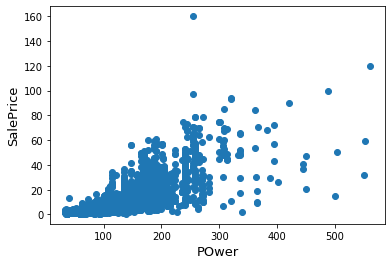

In [7]:
fig,ax=plt.subplots()
ax.scatter(x = train.Power, y = train.Price)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('POwer', fontsize=13)
plt.show()

In [8]:
train_df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998.0,58.16,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582.0,126.20,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199.0,88.70,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248.0,88.76,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968.0,140.80,5.0,NaN,17.74


In [9]:
train_df.Price.isnull().sum()


0

#### 86% of new price value is nan so we drop that col in train

In [10]:
x.New_Price.isnull().sum()/x.shape[0]

0.8631001827546104

In [11]:
x.shape

(6019, 12)

#### 85% of new price value is nan so we drop that col in test

In [12]:
x1.New_Price.isnull().sum()/x1.shape[0]

0.8525121555915721

In [13]:
x.drop(columns=['New_Price'],inplace=True)
x1.drop(columns='New_Price',inplace=True)


In [14]:
#source for s.str.split(expand=True)
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html

#source for spliting name into two seperate col
#df[['First','Last']] = df.Name.str.split(" ",expand=True,)
#http://cmdlinetips.com/2018/11/how-to-split-a-text-column-in-pandas/


x[['Brand','Model']]=x.Name.str.split(" ",n=1,expand=True)
x.drop(columns='Name',inplace=True)

x1[['Brand','Model']]=x1.Name.str.split(" ",n=1,expand=True)
x1.drop(columns='Name',inplace=True)

col=x.columns.to_list()
col=col[-2:]+col[:-2]
x=x[col]
x1=x1[col]

In [15]:
# kmkg='km/kg'
# x1[x1.Mileage.str.split(' ').str[1]=='km/kg']

In [16]:
def string_mani(val):
    if(val.split(' ')[1]=='km/kg'):
        return float(val.split(' ')[0])*0.425143707
    elif(val!=np.nan):
        return float(val.split(' ')[0])
    else:
        return val

In [17]:
x1.Mileage=x1.Mileage.apply(lambda x:string_mani(x))
x1.Mileage=x1.Mileage.astype(np.float32)

#### here some values are nan so skip those

In [18]:
x.Mileage=x.Mileage[x.Mileage.notnull()].apply(lambda x:string_mani(x))
x.Mileage=x.Mileage.astype(np.float32)

In [19]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
Brand                6019 non-null object
Model                6019 non-null object
Location             6019 non-null object
Year                 6019 non-null int64
Kilometers_Driven    6019 non-null int64
Fuel_Type            6019 non-null object
Transmission         6019 non-null object
Owner_Type           6019 non-null object
Mileage              6017 non-null float32
Engine               5983 non-null object
Power                5983 non-null object
Seats                5977 non-null float64
dtypes: float32(1), float64(1), int64(2), object(8)
memory usage: 540.8+ KB


**check if power and engine also has sepearate units and its having unique unit so no problem**

In [20]:
print(set(x[x.Power.notnull()].Power.apply(lambda x: x.split(' ')[1])))
print(set(x[x.Engine.notnull()].Engine.apply(lambda x: x.split(' ')[1])))

{'bhp'}
{'CC'}


In [21]:
x1[['Power','Engine']]=x1[['Power','Engine']].apply(lambda x: x.str.split(' ').str[0])

In [22]:
x[['Power','Engine']]=x[['Power','Engine']].apply(lambda x: x.str.split(' ').str[0])

In [23]:
x.Mileage=pd.to_numeric(x.Mileage)
x.Power=pd.to_numeric(x.Power,errors='coerce')
x.Engine=pd.to_numeric(x.Engine,errors='coerce')

x1.Mileage=pd.to_numeric(x1.Mileage)
x1.Power=pd.to_numeric(x1.Power,errors='coerce')
x1.Engine=pd.to_numeric(x1.Engine,errors='coerce')

In [24]:
x.isnull().sum()

Brand                  0
Model                  0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
dtype: int64

In [25]:
x1.isnull().sum()

Brand                 0
Model                 0
Location              0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               0
Engine               10
Power                32
Seats                11
dtype: int64

In [26]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
Brand                6019 non-null object
Model                6019 non-null object
Location             6019 non-null object
Year                 6019 non-null int64
Kilometers_Driven    6019 non-null int64
Fuel_Type            6019 non-null object
Transmission         6019 non-null object
Owner_Type           6019 non-null object
Mileage              6017 non-null float32
Engine               5983 non-null float64
Power                5876 non-null float64
Seats                5977 non-null float64
dtypes: float32(1), float64(3), int64(2), object(6)
memory usage: 540.8+ KB


In [27]:
x1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 12 columns):
Brand                1234 non-null object
Model                1234 non-null object
Location             1234 non-null object
Year                 1234 non-null int64
Kilometers_Driven    1234 non-null int64
Fuel_Type            1234 non-null object
Transmission         1234 non-null object
Owner_Type           1234 non-null object
Mileage              1234 non-null float32
Engine               1224 non-null float64
Power                1202 non-null float64
Seats                1223 non-null float64
dtypes: float32(1), float64(3), int64(2), object(6)
memory usage: 110.9+ KB


In [28]:
x.groupby(by=['Brand','Model']).first().head()

Location  Year  Kilometers_Driven Fuel_Type  \
Brand      Model                                                                
Ambassador Classic Nova Diesel     Chennai  2003              80000    Diesel   
Audi       A3 35 TDI Attraction    Chennai  2014              79271    Diesel   
           A3 35 TDI Premium        Mumbai  2016              20003    Diesel   
           A3 35 TDI Premium Plus   Mumbai  2016              39000    Diesel   
           A3 35 TDI Technology      Delhi  2017              22000    Diesel   

                                  Transmission Owner_Type    Mileage  Engine  \
Brand      Model                                                               
Ambassador Classic Nova Diesel          Manual      Third  12.800000  1489.0   
Audi       A3 35 TDI Attraction      Automatic      First  20.379999  1968.0   
           A3 35 TDI Premium         Automatic      First  20.379999  1968.0   
           A3 35 TDI Premium Plus    Automatic      First  20.379999  1968.0   
           A3 35 TDI Technology      Automatic     Second  20.379999  1968.0   

                                   Power  Seats  
Brand      Model                                 
Ambassador Classic Nova Diesel      35.5    5.0  
Audi       A3 35 TDI Attraction    143.0    5.0  
           A3 35 TDI Premium       143.0    5.0  
           A3 35 TDI Premium Plus  143.0    5.0  
           A3 35 TDI Technology    143.0    5.0

In [29]:
x.loc[4446,:]

Brand                   Mahindra
Model                E Verito D4
Location                 Chennai
Year                        2016
Kilometers_Driven          50000
Fuel_Type               Electric
Transmission           Automatic
Owner_Type                 First
Mileage                      NaN
Engine                        72
Power                         41
Seats                          5
Name: 4446, dtype: object

In [30]:
train[train.Mileage.isnull()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,5.0,13.58 Lakh,13.00
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,NaN,12.75


In [31]:
# x.Mileage.value_counts().sort_index()

**fill mileage column having 68 rows having 0 with np.nan**

In [32]:
x.Mileage=x.Mileage.apply(lambda x: np.nan if x<1 else x)

In [33]:
x['Mileage'] = x.groupby(['Brand','Model'])['Mileage'].transform(lambda x: x.fillna(x.median()))
x['Power'] = x.groupby(['Brand','Model'])['Power'].transform(lambda x: x.fillna(x.median()))
x['Engine'] = x.groupby(['Brand','Model'])['Engine'].transform(lambda x: x.fillna(x.median()))
x['Seats'] = x.groupby(['Brand','Model'])['Seats'].transform(lambda x: x.fillna(x.median()))

In [34]:
x1['Mileage'] = x1.groupby(['Brand','Model'])['Mileage'].transform(lambda x: x.fillna(x.median()))
x1['Power'] = x1.groupby(['Brand','Model'])['Power'].transform(lambda x: x.fillna(x.median()))
x1['Engine'] = x1.groupby(['Brand','Model'])['Engine'].transform(lambda x: x.fillna(x.median()))
x1['Seats'] = x1.groupby(['Brand','Model'])['Seats'].transform(lambda x: x.fillna(x.median()))

**here still the nan persists**


In [35]:
x['Mileage'] =x.groupby(['Brand','Fuel_Type','Transmission'])['Mileage'].transform(lambda x: x.fillna(x.median()))
x['Power'] = x.groupby([ 'Brand','Fuel_Type','Transmission'])['Power'].transform(lambda x: x.fillna(x.median()))
x['Engine'] = x.groupby(['Brand','Fuel_Type','Transmission'])['Engine'].transform(lambda x: x.fillna(x.median()))
x['Seats'] = x.groupby([ 'Brand','Fuel_Type','Transmission'])['Seats'].transform(lambda x: x.fillna(x.median()))

In [36]:
x1['Mileage'] =x1.groupby(['Brand','Fuel_Type','Transmission'])['Mileage'].transform(lambda x: x.fillna(x.median()))
x1['Power'] =  x1.groupby([ 'Brand','Fuel_Type','Transmission'])['Power'].transform(lambda x: x.fillna(x.median()))
x1['Engine'] = x1.groupby(['Brand','Fuel_Type','Transmission'])['Engine'].transform(lambda x: x.fillna(x.median()))
x1['Seats'] =  x1.groupby([ 'Brand','Fuel_Type','Transmission'])['Seats'].transform(lambda x: x.fillna(x.median()))

**even now exixts one or 2**

In [37]:
x['Mileage'] =x.groupby(['Brand'])['Mileage'].transform(lambda x: x.fillna(x.median()))
x['Power'] = x.groupby([ 'Brand'])['Power'].transform(lambda x: x.fillna(x.median()))
x['Engine'] = x.groupby(['Brand'])['Engine'].transform(lambda x: x.fillna(x.median()))
x['Seats'] = x.groupby([ 'Brand'])['Seats'].transform(lambda x: x.fillna(x.median()))



In [38]:
x1['Mileage'] =x1.groupby(['Brand'])['Mileage'].transform(lambda x: x.fillna(x.median()))
x1['Power'] =  x1.groupby(['Brand'])['Power'].transform(lambda x: x.fillna(x.median()))
x1['Engine'] = x1.groupby(['Brand'])['Engine'].transform(lambda x: x.fillna(x.median()))
x1['Seats'] =  x1.groupby(['Brand'])['Seats'].transform(lambda x: x.fillna(x.median()))


In [39]:
x1['Power'] =  x1.Power.transform(lambda x: x.fillna(x.median()))
x['Power'] = x.Power.transform(lambda x: x.fillna(x.median()))

In [40]:
x[x.Mileage<5].Mileage

Series([], Name: Mileage, dtype: float64)

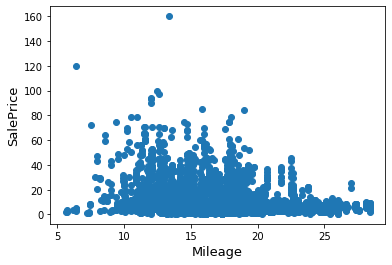

In [41]:
fig,ax=plt.subplots()
ax.scatter(x = x.Mileage, y = train.Price)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('Mileage', fontsize=13)
plt.show()

In [42]:
x['train']=1
x1['train']=0

In [43]:
combined=pd.concat([x,x1])

In [44]:
categorical_feature_mask = combined.dtypes==object
categorical_cols = combined.columns[categorical_feature_mask].tolist()
categorical_cols

['Brand', 'Model', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type']

In [45]:
le = LabelEncoder()

combined[categorical_cols] = combined[categorical_cols].apply(lambda col: le.fit_transform(col))
combined[categorical_cols].head(10)

,Brand,Model,Location,Fuel_Type,Transmission,Owner_Type
0,19,1797,9,0,1,0
1,11,498,10,1,1,0
2,10,993,2,4,1,0
3,19,676,2,1,1,0
4,1,105,3,1,0,2
5,11,591,5,3,1,0
6,23,1101,6,1,1,0
7,30,973,9,1,0,0
8,31,1699,10,1,1,0
9,29,908,2,1,1,2


In [46]:

new_x  = combined[combined['train'] == 1].copy()
new_x1 = combined[combined['train']==0].copy()
new_x.drop(columns= 'train',inplace=True,axis=1)
new_x1.drop(columns='train',inplace=True,axis=1)


In [47]:
X_train, X_val, Y_train, Y_val = train_test_split(new_x, y, test_size = 0.1, random_state = 1)

In [48]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4) 
print(kf.get_n_splits(new_x))

print(kf) 

4
KFold(n_splits=4, random_state=None, shuffle=False)


In [49]:
for train_index, test_index in kf.split(new_x):
    print("TRAIN:", train_index, "TEST", test_index)
#     X_train, X_val = new_x[train_index], new_x[test_index]
#     Y_train, Y_val = y[train_index], y[test_index]

TRAIN: [1505 1506 1507 ... 6016 6017 6018] TEST [   0    1    2 ... 1502 1503 1504]
TRAIN: [   0    1    2 ... 6016 6017 6018] TEST [1505 1506 1507 ... 3007 3008 3009]
TRAIN: [   0    1    2 ... 6016 6017 6018] TEST [3010 3011 3012 ... 4512 4513 4514]
TRAIN: [   0    1    2 ... 4512 4513 4514] TEST [4515 4516 4517 ... 6016 6017 6018]


In [50]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#Scaling Original Training Data
new_x = sc.fit_transform(new_x)

#Reshaping vector to array for transforming
y = y.reshape((len(y), 1))
y = sc.fit_transform(y)
#converting back to vector
y = y.ravel()

new_x1 = sc.transform(new_x1)

# Scaling Splitted training and val sets
X_train = sc.fit_transform(X_train)
X_val = sc.fit_transform(X_val)

#Reshaping vector to array for transforming
Y_train = Y_train.reshape((len(Y_train), 1)) 
Y_train = sc.fit_transform(Y_train)
#converting back to vector
Y_train = Y_train.ravel()

In [51]:
def score(y_pred, y_true):
   error = np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean() ** 0.5
   score = 1 - error
   return score

#The actual recordings to be tested against
# y_true = Y_val

In [56]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42,
                            silent=0) 

In [57]:
model.fit(X_train,Y_train)

[20:13:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=0, subsample=0.6, verbosity=1)

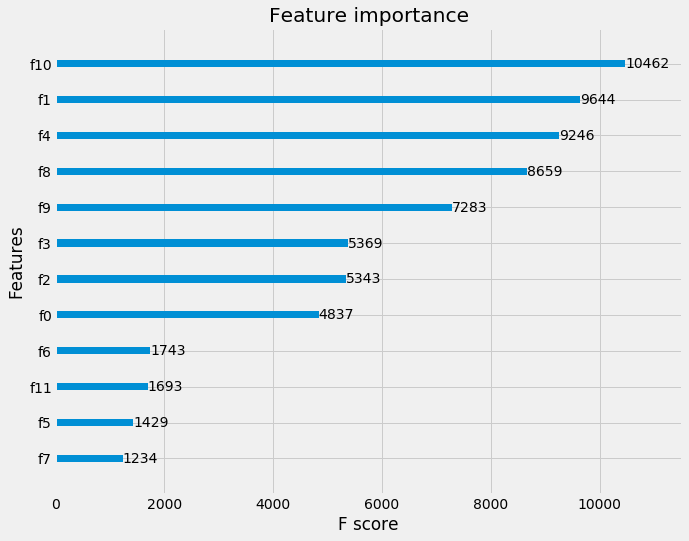

In [58]:
# set figsize

from IPython.core.pylabtools import figsize
figsize(10,8)

# plot styple
plt.style.use('fivethirtyeight')

# plot feature importance
xgboost.plot_importance(model)

In [59]:
X_train.shape

(5417, 12)

In [60]:
# Y_pred=sc.inverse_transform(model.predict(X_val))

In [61]:
for i in range(len(Y_pred)):
   if Y_pred[i] < 0:
       Y_pred[i] = 0

#Printing the score for validation sets
print("\n\n xg boost SCORE : ", score(Y_pred, Y_val))
print("xg boost SCORE :  0.8769390593926911")
# score(aa,Y_val)

xg boost SCORE :  0.8769390593926911


In [62]:
model.fit(new_x,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1.5, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=0, subsample=0.6, verbosity=1)


In [63]:
Y_pred2=sc.inverse_transform(model.predict(new_x1))

In [64]:
for i in range(len(Y_pred2)):
   if Y_pred2[i] < 0:
       Y_pred2[i] = 0

In [65]:
pd.DataFrame(Y_pred2, columns = ['Price']).to_excel("predictions11.xlsx",index=False)